###  Update From 12/29
#### Zihan

+ revised single factor into generic evaluations - [done]
+ for each feature, compute the sharpe ratio for cutoff ranging from 0.5 to 0.9 [done]
+ generate binary feature out of the previous computed mappings [done]
+ don't think adding article and alert would be helpful - will explain in person
+ aggregate sentiment into weekly and biweekly 


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import operator

with open('sectorMapping.pkl', 'rb') as f:
    sectorMapping = pickle.load(f)

df = pd.read_csv("ALL.csv")
df = df[abs(df.returnsOpenNextMktres10) < 0.40] # remove outlier
df['sector'] = df.assetCode.apply(lambda x: sectorMapping[x.split(".")[0]]) # create sector column

In [8]:
# single factor evaluation in a functional way

'''
helper function for single_factor_eva: top cut_off % short, else long
'''
def single_factor_helper(df, score, cut_off):
    d = {}
    sorted_df = df.sort_values(score).reset_index(drop=True)
    index = int(len(sorted_df) * cut_off)
    short_portfolio = np.mean(sorted_df['returnsOpenNextMktres10'][:index])
    long_portfolio = np.mean(sorted_df['returnsOpenNextMktres10'][index:])
    d['daily_return'] = long_portfolio - short_portfolio
    return pd.Series(d, index=['daily_return'])

'''
evaluate how well a single factor performs given its column name and a cutoff
    e.g. when cutoff is set to be 0.9, it means we short top 10%, and long 90%
@param cut_off float
@param score str name of the factor
@param df dataframe which must contain score column and returnsOpenNextMktres10
return NaN only plot and statistics
'''
def single_factor_eva(df, score, cut_off=0.5, sector_code=None, all_on=False):
    
    print("\n *** evaluating factor :", score)
    if sector_code != None:
        print("\n *** sector: ", sector_code)
        factor_return = df.groupby('datetime').apply(lambda x: single_factor_helper(x, score, cut_off))
        sector_return = df.groupby('datetime').apply(lambda x: single_factor_helper(x[x.sector == sector_code], score, cut_off))
        print(" *** Overall Sharpe ratio:", float(factor_return.mean() / factor_return.std()))
        print(" *** Sector Sharpe ratio:", float(sector_return.mean() / sector_return.std()))
        factor_return['cumsum'] = factor_return.daily_return.cumsum()
        sector_return['cumsum'] = sector_return.daily_return.cumsum()
        plt.figure()
        plt.plot(list(factor_return['cumsum']), label = score+"_"+str(cut_off))
        plt.plot(list(sector_return['cumsum']), label = score+"_"+str(cut_off)+"_sector_" +str(sector_code))
        plt.legend()
        plt.savefig(score+"_"+str(cut_off)+"_sector_" +str(sector_code) +'.png')
        plt.show()
        return
    
    if all_on:
        plt.figure()
        cutoff_sharpe_dict = dict()
        df_group = df.groupby('datetime')
        for i in [0.1 * i for i in range(1, 10)]:
            cutoff_return = df_group.apply(lambda x: single_factor_helper(x, score, i))
            cutoff_sharpe_dict[round(i, 1)] = float(cutoff_return.mean() / cutoff_return.std())
            cutoff_return['cumsum'] = cutoff_return.daily_return.cumsum()
            plt.plot(list(cutoff_return['cumsum']), label = str(int(i * 100))+"%")
        plt.legend()
        title = ""
        for key in cutoff_sharpe_dict:
            title = title + str(key) + ": " + str(round(cutoff_sharpe_dict[key], 3)) + "\n"
        plt.title(score+":\n"+title)
        plt.savefig('./cutoff_images_v2/' + score + '.png', bbox_inches='tight')
        plt.show()    
        return cutoff_sharpe_dict
    
    factor_return = df.groupby('datetime').apply(lambda x: single_factor_helper(x, score, cut_off))
    factor_return['cumsum'] = factor_return.daily_return.cumsum()
    plt.figure()
    plt.plot(list(factor_return['cumsum']), label = score+"_"+str(int(cut_off * 100))+"%")
    plt.legend()
    plt.savefig(score+"_"+str(cut_off)+'.png')
    plt.show()  

### Examine Sector In and Out Performance with various cutoffs

In [6]:
examine_ls = [ 'alert_relevance_weighted_sentiment',
       'alert_relevance_weighted_negative_sentiment',
       'alert_relevance_weighted_positive_sentiment',
       'alert_relevance_weighted_neutral_sentiment',
       'alert_news_volume_sum_12H', 'alert_news_novelty_sum_12H',
       'alert_news_volume_sum_24H', 'alert_news_novelty_sum_24H',
       'alert_news_volume_sum_3D', 'alert_news_novelty_sum_3D',
       'alert_news_volume_sum_5D', 'alert_news_novelty_sum_5D',
       'alert_news_volume_sum_7D', 'alert_news_novelty_sum_7D',
       'article_relevance_weighted_sentiment',
       'article_relevance_weighted_negative_sentiment',
       'article_relevance_weighted_positive_sentiment',
       'article_relevance_weighted_neutral_sentiment',
       'article_news_volume_sum_12H', 'article_news_novelty_sum_12H',
       'article_news_volume_sum_24H', 'article_news_novelty_sum_24H',
       'article_news_volume_sum_3D', 'article_news_novelty_sum_3D',
       'article_news_volume_sum_5D', 'article_news_novelty_sum_5D',
       'article_news_volume_sum_7D', 'article_news_novelty_sum_7D',
       'relevance_weighted_sentiment', 'relevance_weighted_negative_sentiment',
       'relevance_weighted_positive_sentiment',
       'relevance_weighted_neutral_sentiment', 'news_volume_sum_12H',
       'news_novelty_sum_12H', 'news_volume_sum_24H', 'news_novelty_sum_24H',
       'news_volume_sum_3D', 'news_novelty_sum_3D', 'news_volume_sum_5D',
       'news_novelty_sum_5D', 'news_volume_sum_7D', 'news_novelty_sum_7D']


 *** evaluating factor : alert_relevance_weighted_sentiment


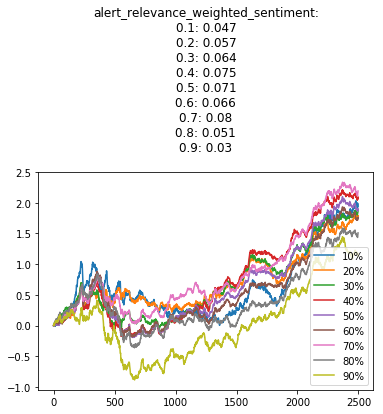


 *** evaluating factor : alert_relevance_weighted_negative_sentiment


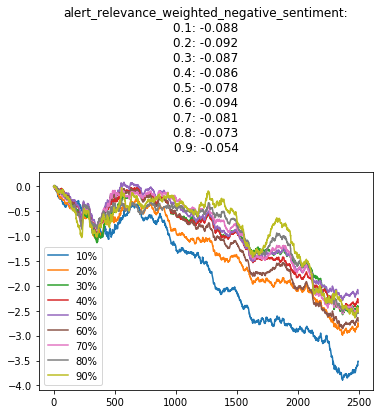


 *** evaluating factor : alert_relevance_weighted_positive_sentiment


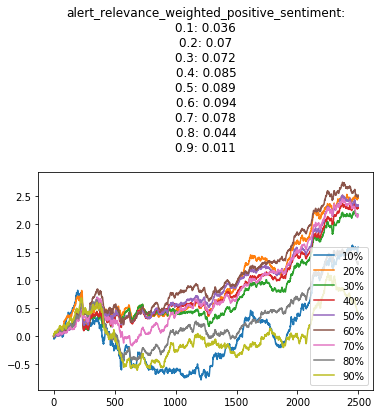


 *** evaluating factor : alert_relevance_weighted_neutral_sentiment


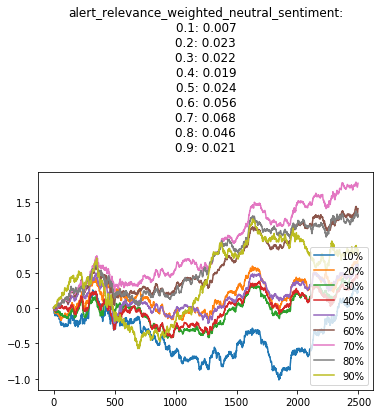


 *** evaluating factor : alert_news_volume_sum_12H


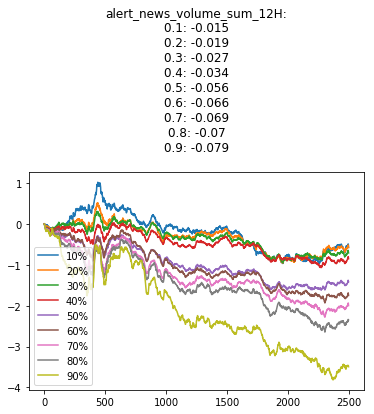


 *** evaluating factor : alert_news_novelty_sum_12H


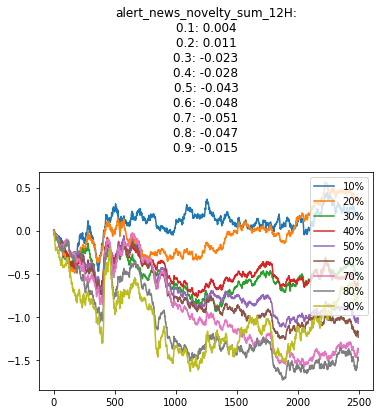


 *** evaluating factor : alert_news_volume_sum_24H


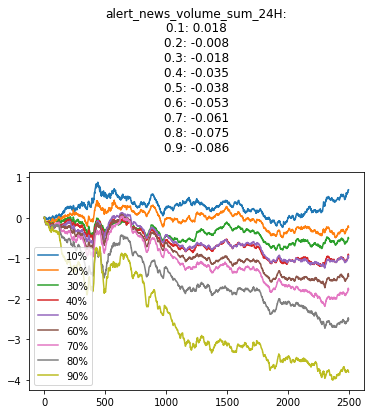


 *** evaluating factor : alert_news_novelty_sum_24H


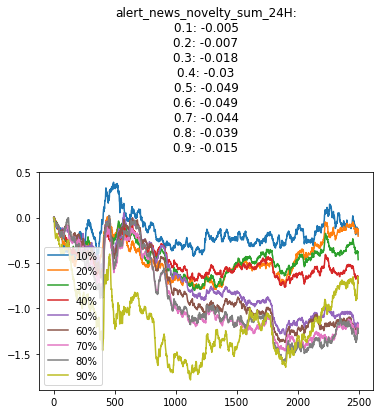


 *** evaluating factor : alert_news_volume_sum_3D


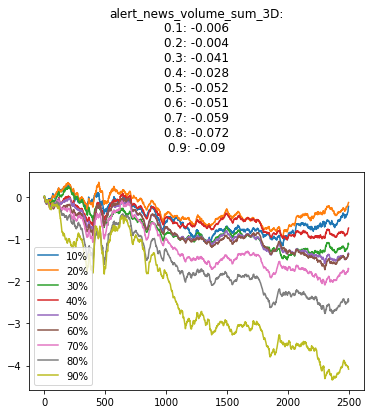


 *** evaluating factor : alert_news_novelty_sum_3D


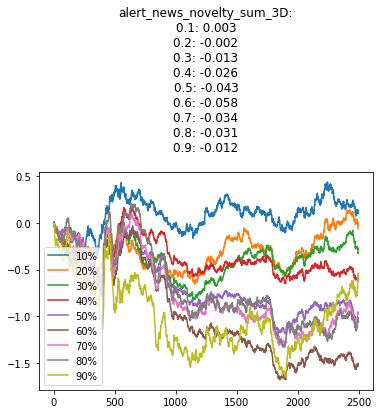


 *** evaluating factor : alert_news_volume_sum_5D


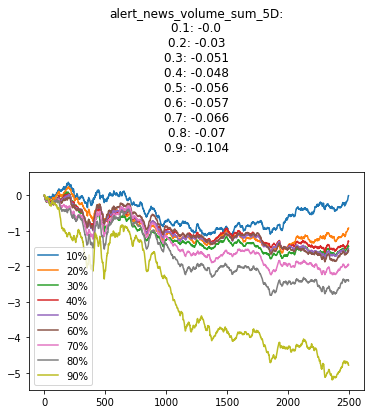


 *** evaluating factor : alert_news_novelty_sum_5D


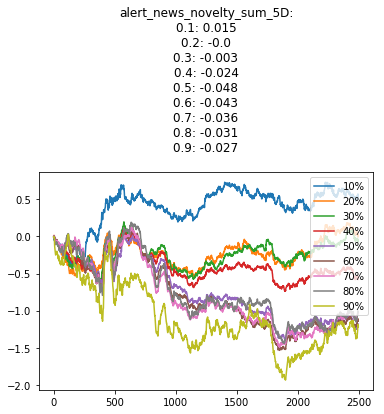


 *** evaluating factor : alert_news_volume_sum_7D


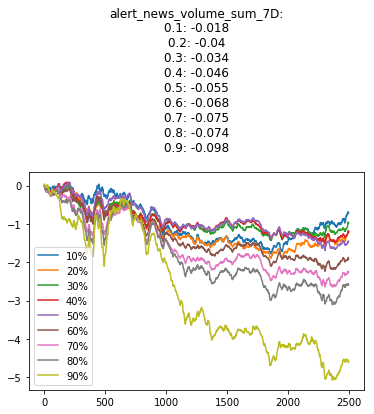


 *** evaluating factor : alert_news_novelty_sum_7D


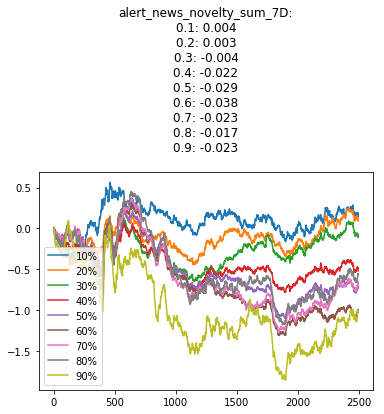


 *** evaluating factor : article_relevance_weighted_sentiment


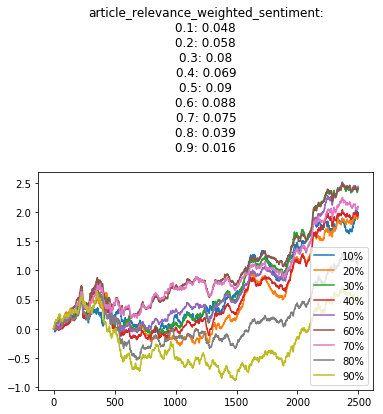


 *** evaluating factor : article_relevance_weighted_negative_sentiment


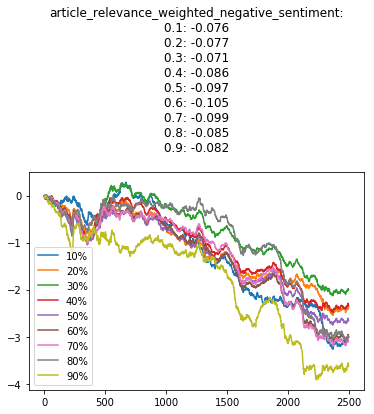


 *** evaluating factor : article_relevance_weighted_positive_sentiment


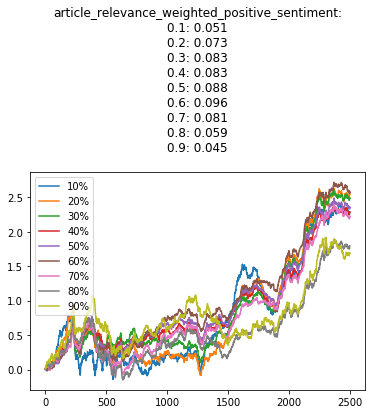


 *** evaluating factor : article_relevance_weighted_neutral_sentiment


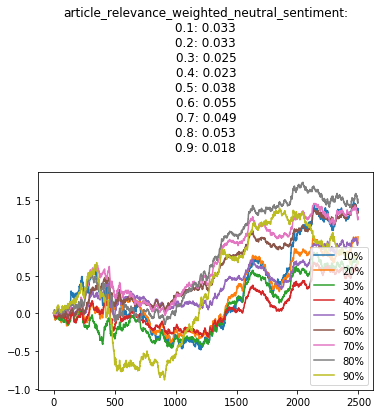


 *** evaluating factor : article_news_volume_sum_12H


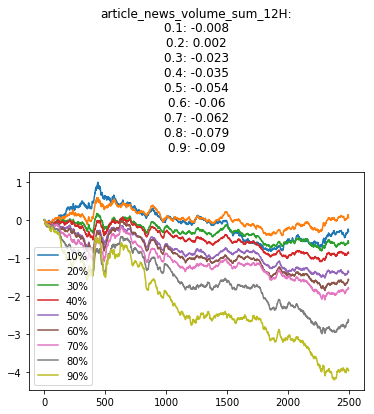


 *** evaluating factor : article_news_novelty_sum_12H


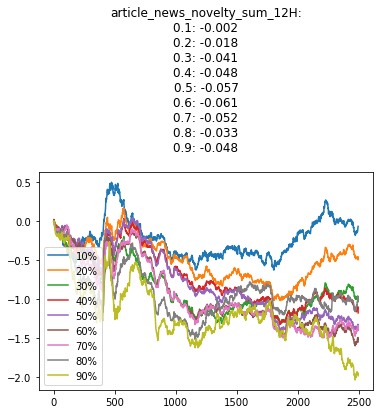


 *** evaluating factor : article_news_volume_sum_24H


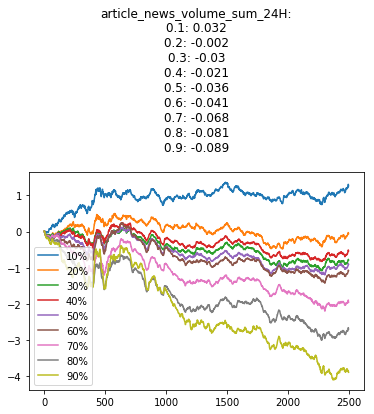


 *** evaluating factor : article_news_novelty_sum_24H


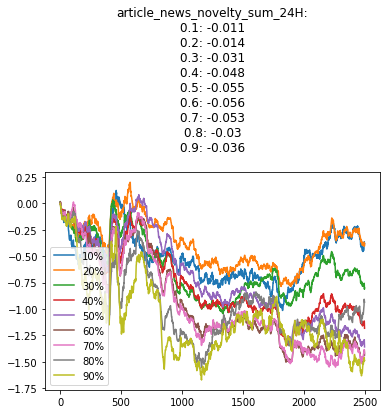


 *** evaluating factor : article_news_volume_sum_3D


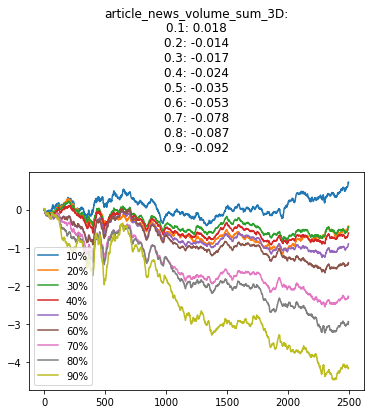


 *** evaluating factor : article_news_novelty_sum_3D


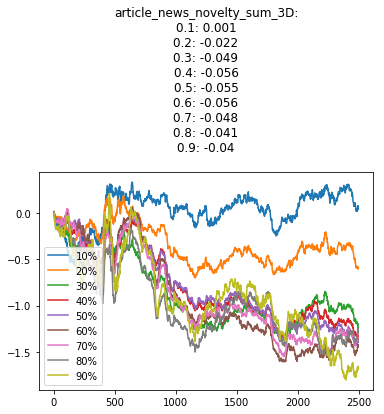


 *** evaluating factor : article_news_volume_sum_5D


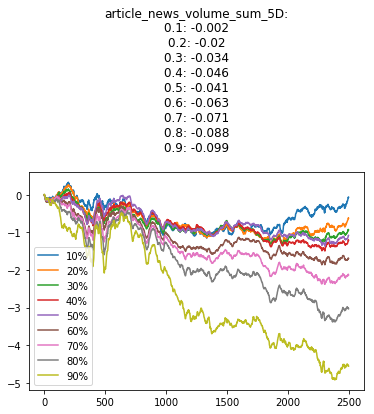


 *** evaluating factor : article_news_novelty_sum_5D


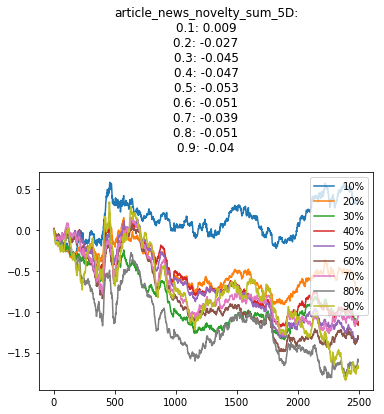


 *** evaluating factor : article_news_volume_sum_7D


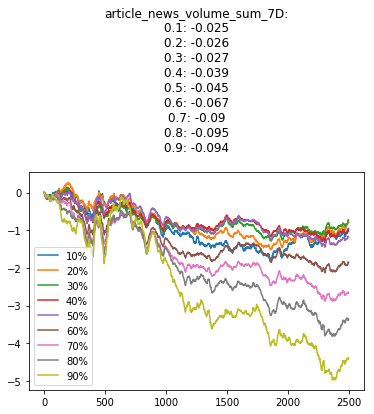


 *** evaluating factor : article_news_novelty_sum_7D


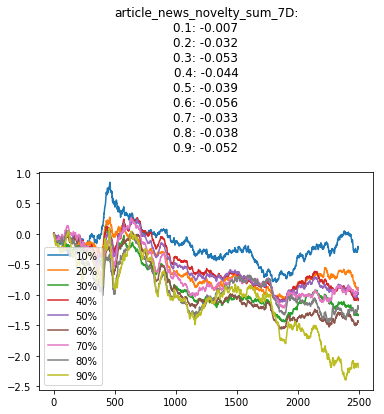


 *** evaluating factor : relevance_weighted_sentiment


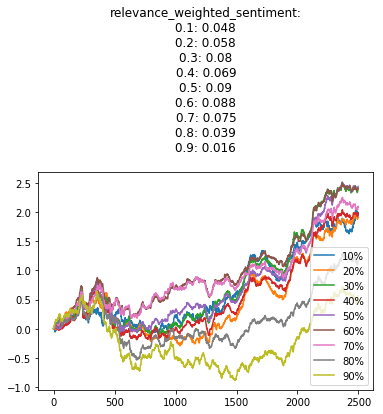


 *** evaluating factor : relevance_weighted_negative_sentiment


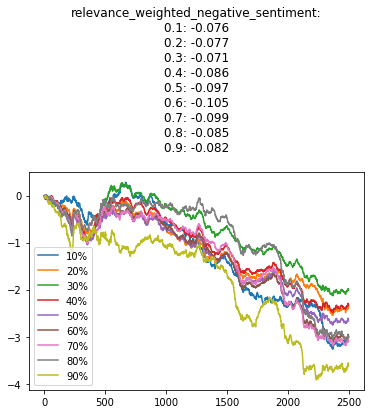


 *** evaluating factor : relevance_weighted_positive_sentiment


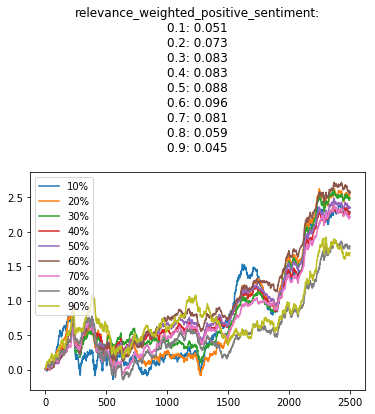


 *** evaluating factor : relevance_weighted_neutral_sentiment


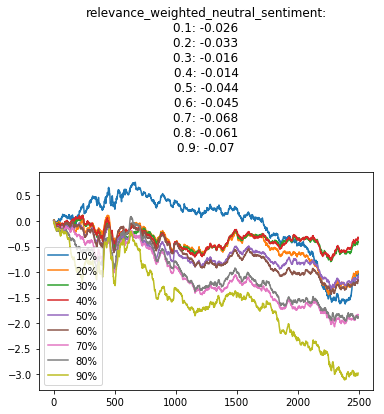


 *** evaluating factor : news_volume_sum_12H


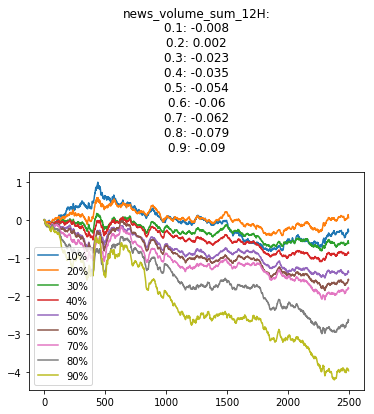


 *** evaluating factor : news_novelty_sum_12H


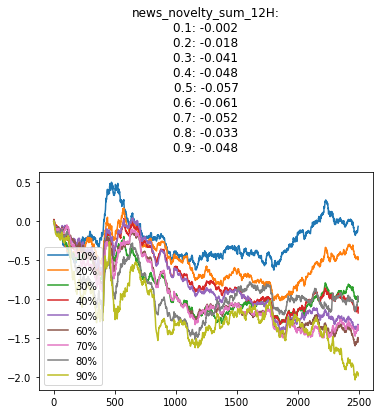


 *** evaluating factor : news_volume_sum_24H


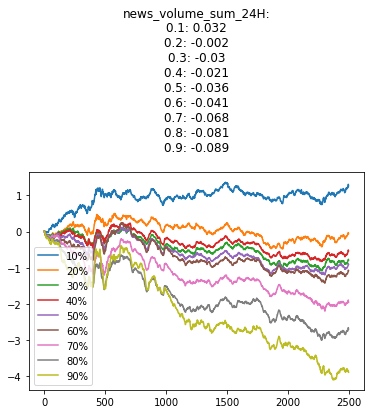


 *** evaluating factor : news_novelty_sum_24H


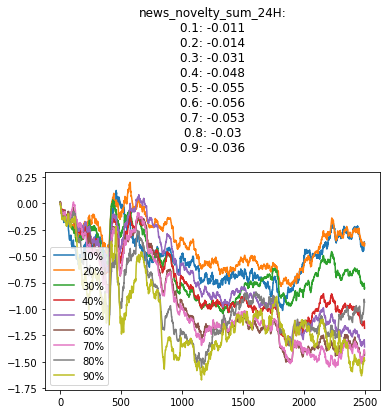


 *** evaluating factor : news_volume_sum_3D


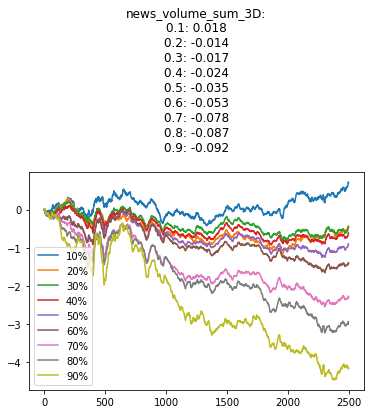


 *** evaluating factor : news_novelty_sum_3D


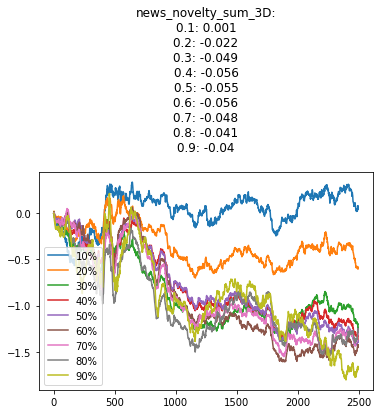


 *** evaluating factor : news_volume_sum_5D


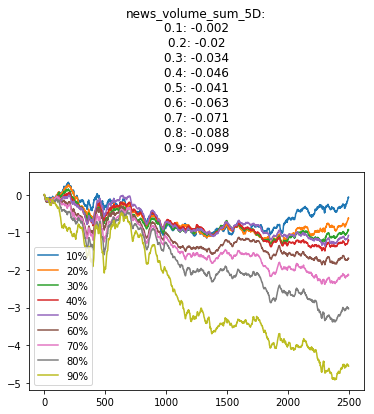


 *** evaluating factor : news_novelty_sum_5D


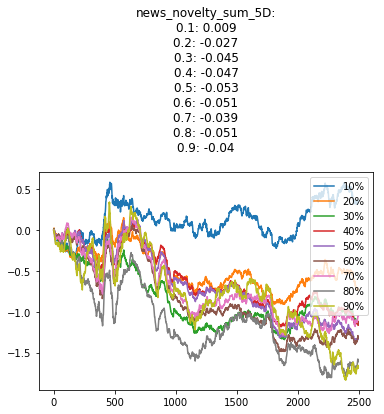


 *** evaluating factor : news_volume_sum_7D


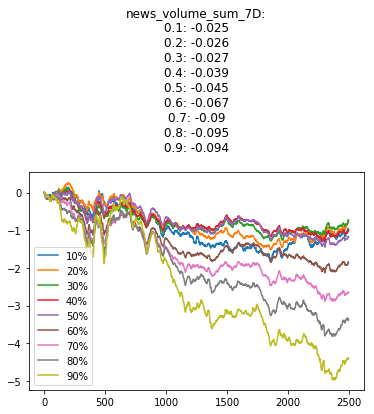


 *** evaluating factor : news_novelty_sum_7D


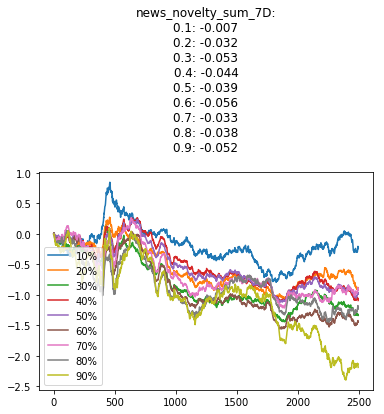

In [9]:
# run all sentiment related features and save them in local directory

sentiment_cutoff_dict = dict()
for i in examine_ls:
    sentiment_cutoff_dict[i] = single_factor_eva(df, i, all_on=True)

In [36]:
cutoff_df = pd.DataFrame(sentiment_cutoff_dict) # df is good for column wise operations
cutoff_df = cutoff_df.abs()  # extreme is good, sign is not

# # uncomment to inspect rank
# cutoff_df.max().sort_values(ascending=False) # find top k by mean or max
# cutoff_df.mean().sort_values(ascending=False)

# maually selected top k most important features
top_k_factors = [
    'article_relevance_weighted_negative_sentiment',
    'article_news_volume_sum_5D',
    'article_relevance_weighted_positive_sentiment',
    'alert_news_volume_sum_5D',
    'alert_relevance_weighted_positive_sentiment',
    'alert_relevance_weighted_negative_sentiment',
    'article_news_novelty_sum_12H',
    'alert_news_novelty_sum_3D'
]

In [21]:
'''
given column name like: 'article_relevance_weighted_negative_sentiment'
return the quantile cutoff based on optimal single factor evaluation
'''
def cutoff_lookup(i):
    return cutoff_df[i].sort_values(ascending=False).index[0]

# test case for cutoff_lookup function - used min here because original dict had negative value for this feature
assert(cutoff_lookup('article_relevance_weighted_negative_sentiment') == \
       min(sentiment_cutoff_dict['article_relevance_weighted_negative_sentiment'].items(), key=operator.itemgetter(1))[0])
print("cutoff_lookup test case passed!")

cutoff_lookup test case passed!


In [113]:
# # test case for bin_top_k_sentiment_factors

# '''
# provide a top_k_factors list of columns names, and df that contains them
# return only the top k sentiment factors in binary encoding based on their optimal sharpe dict obtained earlier
# '''
# def bin_top_k_sentiment_factors(df, top_k_factors):
#     d = {}
#     for factor in top_k_factors:
#         sorted_df = df.sort_values(factor).reset_index(drop=True)
#         index = int(len(sorted_df) * cutoff_lookup(factor))
#         index_value = float(sorted_df[factor].iloc[[index]])
#         d[factor] = df[factor].apply(lambda x: 1 if x >= index_value else -1)
#     d['returnsOpenNextMktres10'] = df.returnsOpenNextMktres10
#     d['datetime'] = df.datetime
#     return pd.DataFrame(d)

# tmp = df.groupby('datetime').apply(lambda x: bin_top_k_sentiment_factors(x, top_k_factors))

# def single_factor_helper(x, score):
#     d = {}
#     short_portfolio = np.mean(x[x[score] == -1].returnsOpenNextMktres10)
#     long_portfolio = np.mean(x[x[score] == 1].returnsOpenNextMktres10)
#     d['daily_return'] = long_portfolio - short_portfolio
#     return pd.Series(d, index=['daily_return'])

e = 10 ** -3
ret = tmp.groupby('datetime').apply(lambda x: single_factor_helper(x, 'alert_relevance_weighted_negative_sentiment'))
assert(min(sentiment_cutoff_dict['alert_relevance_weighted_negative_sentiment'].values()) - float(ret.mean() / ret.std()) < e)
ret = tmp.groupby('datetime').apply(lambda x: single_factor_helper(x, 'alert_relevance_weighted_positive_sentiment'))
assert(max(sentiment_cutoff_dict['alert_relevance_weighted_positive_sentiment'].values()) - float(ret.mean() / ret.std()) < e)
print("binary top k sentiment factor passed test!")

binary top k sentiment factor passed test!


In [115]:
ret = tmp.groupby('datetime').apply(lambda x: single_factor_helper(x, 'alert_news_novelty_sum_3D'))
print(sentiment_cutoff_dict['alert_news_novelty_sum_3D'].values())
print(float(ret.mean() / ret.std()))

dict_values([0.002886952124404871, -0.0021566039573177155, -0.012664848143788867, -0.025859490257008195, -0.04296747244535028, -0.05792754572271414, -0.0342486590073772, -0.03143989883164355, -0.012488294265138129])
-0.04016692044487653


In [ ]:
# demo code of running all sector comparison for 'alert_relevance_weighted_positive_sentiment'
for i in list(df.sector.unique()):
    single_factor_eva(df, 'alert_relevance_weighted_positive_sentiment', 0.5, i)